In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

(CVXPY) May 02 07:36:44 PM: Encountered unexpected exception importing solver MOSEK:
AttributeError("module 'mosek' has no attribute 'conetype'")


In [2]:
#################
# generating data

m, n = 500, 200
np.random.seed(2023)

A = np.random.randn(m, n) 
b = np.random.randn(m) 
#################

In [3]:
# question (1)

x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x.sum() == 1]
prob = cp.Problem(objective, constraints)

result = prob.solve()


opt_x = x.value
f_opt = np.linalg.norm(A@np.maximum(opt_x,0)-b)**2/2
print("Optimal value is {}".format(f_opt))

Optimal value is 257.6539356860068


In [4]:
# question (2)

def proj_simplex(y):

    # project y onto the probability simplex x>=0, 1^T x=1
    
    n_features = y.shape[0]
    u = np.sort(y)[::-1]
    cssv = np.cumsum(u) - 1
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    x = np.maximum(y - theta, 0)
    return x

def projected_gradient_descent(x, A, b, max_iter = 100):
    
    # save objective along the trajectory
    obj_trace = np.zeros((max_iter,))
    
    # determine stepsize
    eta = 1/np.linalg.eigvalsh(A.T@A)[-1]
    
    for i in range(max_iter):
        
        x = proj_simplex( x - eta * A.T @ (A @ x - b) )
        
        obj_trace[i] = np.linalg.norm(A@x-b)**2/2
    
    
    
    return x, obj_trace

In [5]:
_, obj_trace1 = projected_gradient_descent(np.ones(n)/n, A, b, max_iter = 30)

In [6]:
# question (3)

def fast_projected_gradient_descent(x, A, b, max_iter = 100):
    
    # save objective along the trajectory
    obj_trace = np.zeros((max_iter,))
    
    # determine stepsize
    eta = 1/np.linalg.eigvalsh(A.T@A)[-1]
    
    x_old = np.copy(x)
    for i in range(max_iter):
        
        
        y = x + (i-2)/(i+1) * (x-x_old)
        x_old = np.copy(x)
        x = proj_simplex( y - eta * A.T @ (A @ y - b) )
        
        obj_trace[i] = np.linalg.norm(A@x-b)**2/2
    
    
    
    return x, obj_trace
    
    

In [7]:
_, obj_trace2 = fast_projected_gradient_descent(np.ones(n)/n, A, b, max_iter = 30)

In [8]:
# question (4)

def mirror_descent(x, A, b, max_iter = 100):
    
    # save objective along the trajectory
    obj_trace = np.zeros((max_iter,))
    
    # determine stepsize
    eta = 1/np.max(np.sum(np.abs(A.T @ A),axis=1))
    
    for i in range(max_iter):
        
        xgrad = A.T @ (A @ x - b)
        # avoid overflow
        xgrad += np.min(xgrad)
        
        x *= np.exp(-eta * xgrad)
        x /= np.sum(x)
        
        obj_trace[i] = np.linalg.norm(A@x-b)**2/2
    
    
    
    return x, obj_trace

In [9]:
_, obj_trace3 = mirror_descent(np.ones(n)/n, A, b, max_iter = 30)

In [10]:
# question (5)

def ADMM(x, A, b, rho = 1, max_iter = 100):
    
    # save objective along the trajectory
    obj_trace = np.zeros((max_iter,))

        
    A_inv = np.linalg.inv(A.T@ A + rho* np.eye(A.shape[1]))
    z = np.copy(x)
    y = np.zeros_like(x)
    for i in range(max_iter):
        
        
        x = A_inv @ (A.T @ b + rho * z - y)
        z = proj_simplex( x + y/rho)
        y += rho * (x-z)
        
        obj_trace[i] = np.linalg.norm(A@z-b)**2/2
    
    
    
    return z, obj_trace

In [11]:
_, obj_trace4 = ADMM(np.ones(n)/n, A, b, rho = 1e3, max_iter = 30)

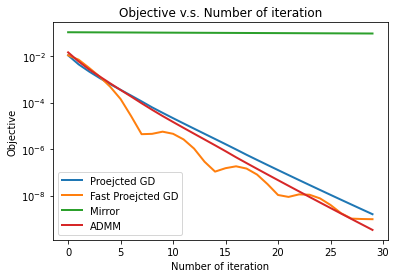

In [12]:
fig, ax = plt.subplots()

# Plot the data using semilogy
ax.semilogy(np.arange(len(obj_trace1)), (obj_trace1-f_opt)/f_opt, linewidth=2, label='Proejcted GD')
ax.semilogy(np.arange(len(obj_trace2)), (obj_trace2-f_opt)/f_opt, linewidth=2, label='Fast Proejcted GD')
ax.semilogy(np.arange(len(obj_trace3)), (obj_trace3-f_opt)/f_opt, linewidth=2, label='Mirror')
ax.semilogy(np.arange(len(obj_trace4)), (obj_trace4-f_opt)/f_opt, linewidth=2, label='ADMM')
# Set labels and title
ax.set_xlabel('Number of iteration')
ax.set_ylabel('Objective')
ax.set_title('Objective v.s. Number of iteration')

# Add a legend
ax.legend()

# Display the plot
plt.show()